# ConversationMemoryManagementSystem

- Author: [syshin0116](https://github.com/syshin0116)
- Design: 
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/05-AIMemoryManagementSystem/09-ConversationMemoryManagementSystem.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/05-AIMemoryManagementSystem/09-ConversationMemoryManagementSystem.ipynb)

## Overview

In modern AI systems, **memory management** is essential for crafting **personalized and context-aware** user experiences. Without the ability to recall prior messages, an AI assistant would quickly become repetitive and less engaging. This updated code demonstrates a robust approach to handling both **short-term** and **long-term** memory in a conversational setting, by integrating:

- A central `Configuration` class for managing runtime parameters (such as `user_id` and model name)
- An `upsert_memory` function for **storing** or **updating** user data in a memory store
- A `call_model` function that **retrieves** context-relevant memories and incorporates them into the system prompt for the model
- A `store_memory` function that **persists** newly identified memories and tool calls
- A `StateGraph` that orchestrates the entire conversation flow, connecting nodes like `call_model` and `store_memory` to streamline user interactions

By leveraging these components, your conversation agent can maintain **deep context** over multiple turns, provide more accurate and engaging responses, and seamlessly update its memory when new information arises. This design illustrates a scalable way to build conversational AI systems that dynamically **remember**, **reason**, and **respond** according to user needs.

### What is Memory?

Memory refers to the capability of an AI system to **store**, **retrieve**, and **use** information. In conversational AI, this typically involves recalling the user’s previous statements, preferences, or relevant context—leading to more **personalized** and **adaptive** interactions.

### Short-term Memory

Short-term memory lets your application remember previous interactions within a single thread or conversation. A thread organizes multiple interactions in a session, similar to the way email groups messages in a single conversation.

LangGraph manages short-term memory as part of the agent's state, persisted via thread-scoped checkpoints. This state can normally include the conversation history along with other stateful data, such as uploaded files, retrieved documents, or generated artifacts. By storing these in the graph's state, the bot can access the full context for a given conversation while maintaining separation between different threads.

Since conversation history is the most common form of representing short-term memory, in the next section, we will cover techniques for managing conversation history when the list of messages becomes long.

### Long-term Memory

Long-term memory extends an AI system's capability to recall information across multiple conversations or sessions. Unlike short-term memory, which focuses on maintaining the context of a single thread, long-term memory stores **persistent information** such as user preferences, key facts, and important events. This enables the system to create a **seamless and personalized user experience** over time.

Long-term memory is typically used to:

- **Recall User Preferences**: For example, remembering a user prefers movie recommendations in a specific genre.
- **Track Progress**: Storing milestones or progress made in ongoing projects or discussions.
- **Adapt Over Time**: Learning about the user’s changing interests or requirements.

In this system, long-term memory is managed through **memory upserts** that save critical user information to a persistent data store. This allows the agent to access, update, and retrieve information beyond a single conversational thread.

### How Long-term Memory Works in LangGraph

In LangGraph, long-term memory is implemented as part of a **persistent data layer**, decoupled from the conversational state. Key components include:

1. **Memory Store**: A database or key-value store where long-term memory records are saved.
2. **Memory Retrieval**: Mechanisms to fetch relevant memories based on the current conversation context.
3. **Memory Updates**: Processes to modify or append new data to existing memory entries when user information evolves.

By linking long-term memory with `call_model` and `store_memory` functions, the system can ensure that the language model has access to **relevant, long-term context**. This makes interactions more coherent and reduces repetitive queries.

#### Challenges with Long-term Memory

- **Scalability**: As the number of users and stored records grows, querying and retrieving relevant memories efficiently becomes a challenge.
- **Relevance Filtering**: Not all past information is useful for every interaction. Filtering out irrelevant data while retaining critical context is key.
- **Data Privacy**: Long-term memory must comply with privacy regulations, ensuring sensitive data is securely handled and stored.


### Short-term vs Long-term Memory

|**Type**|**Scope**|**Purpose**|**Example**|
|---|---|---|---|
|**Short-term Memory**|Single conversational thread|Maintains recent interactions to provide immediate context|Last few user prompts in the current conversation|
|**Long-term Memory**|Multiple threads & sessions|Stores key information and summarized data to maintain continuity across broader conversations|User preferences, important facts, or conversation history|

- **Short-term Memory**: Helps the system focus on the latest messages for immediate context.
- **Long-term Memory**: Enables the agent to recall **past sessions** and user-specific details, creating a more **persistent** experience over time.

### Why use LangGraph's checkpointer?

1. Session Memory & Error Recovery
    
    - Lets you roll back to a previous checkpoint if an error occurs or if you want to resume from a saved state
    - Maintains context across conversations for a more seamless user experience
2. Flexible Database Options & Scalability
    
    - Supports in-memory, SQLite, Postgres, and more, allowing easy scaling as your user base grows
    - Choose the storage method that best fits your project’s needs
3. Human-in-the-Loop & Time Travel
    
    - Pause workflows for human review, then resume where you left off
    - Go back to earlier states (“time travel”) to debug or create alternative paths
4. Ecosystem & Customization
    
    - `LangGraph` v0.2 offers separate checkpointer libraries (e.g., `MemorySaver`, `SqliteSaver`, `PostgresSaver`)
    - Easily build or adapt custom solutions for specific databases or workflows

## Table of Contents

- [Overview](#overview)
    
- [Table of Contents](#table-of-contents)
  
- [Environment Setup](#environment-setup)
    
- [Define System Prompt and Configuration](#define-system-prompt-and-configuration)
    
- [Initialize LLM and Define State Class](#initialize-llm-and-define-state-class)
    
- [Memory Upsert Function](#memory-upsert-function)
    
- [Implement Conversation Flow (call_model, store_memory)](#implement-conversation-flow-call_model-store_memory)
    
- [Define Conditional Edge Logic](#define-conditional-edge-logic)
    
- [Build and Execute StateGraph](#build-and-execute-stategraph)
    
- [Verify Results and View Stored Memories](#verify-results-and-view-stored-memories)
    

### References

- [LangGraph: What-is-memory](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)
- [LangGraph: memory-template](https://github.com/langchain-ai/memory-template)
- [LangChain-ai: memory-agent](https://github.com/langchain-ai/memory-agent)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [],
    verbose=False,
    upgrade=False,
)

No packages to install.


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "ConversationMemoryManagementSystem",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# import for asynchronous tasks
import asyncio
import nest_asyncio

nest_asyncio.apply()

## Define System Prompt and Configuration

This section introduces the `SYSTEM_PROMPT` and the `Configuration` class. They are essential for setting up the system’s behavior and managing environment variables (for example, choosing which language model to use). You can think of `Configuration` as the single source of truth for any settings your application might need.

In [6]:
# Define simple system prompt template used by the chatbot.
SYSTEM_PROMPT = """You are a helpful and friendly chatbot. Get to know the user! \
Ask questions! Be spontaneous! 
{user_info}

System Time: {time}"""

In [7]:
import os
from dataclasses import dataclass, field, fields
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated


# Define the Configuration class to handle runtime settings, including user ID, model name, and system prompt
@dataclass(kw_only=True)
class Configuration:
    """Main configuration class for the memory graph system."""

    user_id: str = "default"
    """The ID of the user to remember in the conversation."""
    model: Annotated[str, {"__template_metadata__": {"kind": "llm"}}] = field(
        default="openai/gpt-4o",
        metadata={
            "description": "The name of the language model to use for the agent. "
            "Should be in the form: provider/model-name."
        },
    )
    system_prompt: str = SYSTEM_PROMPT

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }

        return cls(**{k: v for k, v in values.items() if v})

## Initialize LLM and Define State Class

In this part, we configure the `ChatOpenAI` model (using `model` and `temperature` settings) and introduce a `State` class. The `State` class holds the conversation messages, ensuring that **context** is retained and can be easily passed around. This lays the **foundation** for a conversational agent that genuinely “remembers” what has been said.

In [8]:
# Import and initialize the OpenAI-based LLM
from langchain.chat_models import init_chat_model

llm = init_chat_model()

In [9]:
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from typing_extensions import Annotated
from dataclasses import dataclass


# Define the State class to store the list of messages in the conversation
@dataclass(kw_only=True)
class State:
    """Main graph state."""

    messages: Annotated[list[AnyMessage], add_messages]
    """The messages in the conversation."""

In [10]:
# Define a utility function to split model provider and model name from a string
def split_model_and_provider(fully_specified_name: str) -> dict:
    """Initialize the configured chat model."""
    if "/" in fully_specified_name:
        provider, model = fully_specified_name.split("/", maxsplit=1)
    else:
        provider = None
        model = fully_specified_name
    return {"model": model, "provider": provider}

## Memory Upsert Function

Here, we focus on the `upsert_memory` function. This function is responsible for storing or updating (**upserting**) user-specific data. By preserving user context across conversations—like interests, preferences, or corrections—you can give your application a more **persistent and personalized** feel.

In [11]:
import uuid
from typing import Annotated, Optional

from langchain_core.runnables import RunnableConfig
from langchain_core.tools import InjectedToolArg
from langgraph.store.base import BaseStore


# Define a function to upsert (create or update) memory in the database
async def upsert_memory(
    content: str,
    context: str,
    *,
    memory_id: Optional[uuid.UUID] = None,
    config: Annotated[RunnableConfig, InjectedToolArg],
    store: Annotated[BaseStore, InjectedToolArg],
):
    """Upsert a memory in the database.

    If a memory conflicts with an existing one, then just UPDATE the
    existing one by passing in memory_id - don't create two memories
    that are the same. If the user corrects a memory, UPDATE it.

    Args:
        content: The main content of the memory. For example:
            "User expressed interest in learning about French."
        context: Additional context for the memory. For example:
            "This was mentioned while discussing career options in Europe."
        memory_id: ONLY PROVIDE IF UPDATING AN EXISTING MEMORY.
        The memory to overwrite.
    """
    mem_id = memory_id or uuid.uuid4()
    user_id = Configuration.from_runnable_config(config).user_id
    await store.aput(
        ("memories", user_id),
        key=str(mem_id),
        value={"content": content, "context": context},
    )
    return f"Stored memory {mem_id}"

## Implement Conversation Flow (call_model, store_memory)

Next, we implement two important functions for our conversation flow:

1. `call_model`: Takes the current conversation `State`, retrieves relevant memories, and then sends them along with user messages to the LLM.
2. `store_memory`: Processes the model’s **tool calls**—in this case, requests to store data—and updates the memory store accordingly.

By combining these two functions, the model not only uses past **context** but also augments it with new information in real time.

In [12]:
from datetime import datetime
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore


# Define function to process the user's state and update memory based on conversation context
async def call_model(state: State, config: RunnableConfig, *, store: BaseStore) -> dict:
    """Extract the user's state from the conversation and update the memory."""
    configurable = Configuration.from_runnable_config(config)

    # Retrieve the most recent memories for context
    memories = await store.asearch(
        ("memories", configurable.user_id),
        query=str([m.content for m in state.messages[-3:]]),
        limit=10,
    )

    # Format memories for inclusion in the prompt
    formatted = "\n".join(
        f"[{mem.key}]: {mem.value} (similarity: {mem.score})" for mem in memories
    )
    if formatted:
        formatted = f"""
<memories>
{formatted}
</memories>"""

    # Prepare the system prompt with user memories and current time
    sys = configurable.system_prompt.format(
        user_info=formatted, time=datetime.now().isoformat()
    )
    print("system_msg:", sys)

    # Invoke the language model with the prepared prompt and tools
    msg = await llm.bind_tools([upsert_memory]).ainvoke(
        [{"role": "system", "content": sys}, *state.messages],
        {"configurable": split_model_and_provider(configurable.model)},
    )
    return {"messages": [msg]}

In [13]:
# Define function to process tool calls and store memories in the memory store
async def store_memory(state: State, config: RunnableConfig, *, store: BaseStore):
    # Extract tool calls from the last message
    tool_calls = state.messages[-1].tool_calls

    # Concurrently execute all upsert_memory calls
    saved_memories = await asyncio.gather(
        *(upsert_memory(**tc["args"], config=config, store=store) for tc in tool_calls)
    )

    # Format the results of memory storage operations
    results = [
        {
            "role": "tool",
            "content": mem,
            "tool_call_id": tc["id"],
        }
        for tc, mem in zip(tool_calls, saved_memories)
    ]
    return {"messages": results}

## Define Conditional Edge Logic

In [14]:
# Define a function to determine the next step in the conversation flow
def route_message(state: State):
    """Determine the next step based on the presence of tool calls."""
    msg = state.messages[-1]
    if msg.tool_calls:
        # Route to store_memory if there are tool calls
        return "store_memory"
    # Otherwise, finish
    return END

## Build and Execute StateGraph

In this section, we construct a `StateGraph` to define the flow of the conversation. We specify which node (for instance, `call_model`) leads to which next step (for example, `store_memory`). Once the graph is set, we run sample conversations to see how the system **dynamically** manages user input, retrieves relevant memories, and updates them when necessary.

In [15]:
# Initialize and define the StateGraph, specifying nodes and edges for conversation flow
builder = StateGraph(State, config_schema=Configuration)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge("__start__", "call_model")
builder.add_node(store_memory)
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
# Right now, we're returning control to the user after storing a memory
# Depending on the model, you may want to route back to the model
# to let it first store memories, then generate a response
builder.add_edge("store_memory", "call_model")
graph = builder.compile()
graph.name = "MemoryAgent"

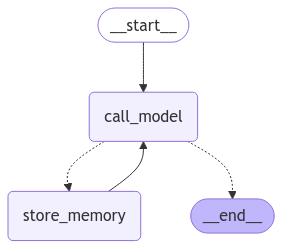

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Verify Results and View Stored Memories

Finally, we examine the stored memories to confirm that our system has correctly captured the user’s context. You can look into the final conversation state (using `graph.get_state`) and see how messages and memories have been organized. This is a great point to do some **debugging** if anything seems amiss, ensuring that your memory mechanism works just as intended.

In [17]:
# Prepare a sample conversation to test the memory agent

conversation = [
    "Hello, I'm Charlie. I work as a software engineer and I'm passionate about AI. Remember this.",
    "I specialize in machine learning algorithms and I'm currently working on a project involving natural language processing.",
    "My main goal is to improve sentiment analysis accuracy in multi-lingual texts. It's challenging but exciting.",
    "We've made some progress using transformer models, but we're still working on handling context and idioms across languages.",
    "Chinese and English have been the most challenging pair so far due to their vast differences in structure and cultural contexts.",
]

In [18]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initialize an in-memory store and compile the graph with a memory saver checkpoint
mem_store = InMemoryStore()

graph = builder.compile(store=mem_store, checkpointer=MemorySaver())
user_id = "test-user"  # temporary user ID for testing
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
    "user_id": user_id,
}

In [19]:
# Process each message in the conversation asynchronously using the compiled graph
for content in conversation:
    async for chunk in graph.astream(
        {"messages": [("user", content)]},
        config=config,
        stream_mode="values",
    ):
        chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Charlie. I work as a software engineer and I'm passionate about AI. Remember this.
system_msg: You are a helpful and friendly chatbot. Get to know the user! Ask questions! Be spontaneous! 


System Time: 2025-01-12T15:54:11.951177
================================== Ai Message ==================================
Tool Calls:
  upsert_memory (call_f3b7nFwOGZZtCzSfqcRyUqVo)
 Call ID: call_f3b7nFwOGZZtCzSfqcRyUqVo
  Args:
    content: Charlie is a software engineer and passionate about AI.
    context: Charlie introduced themselves and shared their profession and interest.
================================= Tool Message =================================

Stored memory 83b21302-d28d-4a7d-b0a9-45f6ab790e37
system_msg: You are a helpful and friendly chatbot. Get to know the user! Ask questions! Be spontaneous! 

<memories>
[83b21302-d28d-4a7d-b0a9-45f6ab790e37]: {'content': 'Charlie is a software enginee

In [20]:
from pprint import pprint

# Search and check stored memories for the user
namespace = ("memories", user_id)
memories = mem_store.search(namespace)
pprint(memories)

[Item(namespace=['memories', 'test-user'], key='83b21302-d28d-4a7d-b0a9-45f6ab790e37', value={'content': 'Charlie is a software engineer and passionate about AI.', 'context': 'Charlie introduced themselves and shared their profession and interest.'}, created_at='2025-01-12T06:54:13.274005+00:00', updated_at='2025-01-12T06:54:13.274006+00:00', score=None),
 Item(namespace=['memories', 'test-user'], key='1d086522-0510-43df-b119-96e66bc8f9d0', value={'content': 'Charlie specializes in machine learning algorithms and is currently working on a project involving natural language processing.', 'context': 'Charlie shared their area of specialization and current project focus.'}, created_at='2025-01-12T06:54:15.285755+00:00', updated_at='2025-01-12T06:54:15.285763+00:00', score=None),
 Item(namespace=['memories', 'test-user'], key='427e0614-8768-44f4-8a01-f01c3cf933d3', value={'content': "Charlie's main goal in their current project is to improve sentiment analysis accuracy in multi-lingual tex

In [21]:
# Test memory recall by asking a question. Notice the memory the agent recalls.
async for chunk in graph.astream(
    {"messages": [("user", "Whats my name?")]},
    config=config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Whats my name?
system_msg: You are a helpful and friendly chatbot. Get to know the user! Ask questions! Be spontaneous! 

<memories>
[83b21302-d28d-4a7d-b0a9-45f6ab790e37]: {'content': 'Charlie is a software engineer and passionate about AI.', 'context': 'Charlie introduced themselves and shared their profession and interest.'} (similarity: None)
[1d086522-0510-43df-b119-96e66bc8f9d0]: {'content': 'Charlie specializes in machine learning algorithms and is currently working on a project involving natural language processing.', 'context': 'Charlie shared their area of specialization and current project focus.'} (similarity: None)
[427e0614-8768-44f4-8a01-f01c3cf933d3]: {'content': "Charlie's main goal in their current project is to improve sentiment analysis accuracy in multi-lingual texts.", 'context': 'Charlie described the primary goal and challenge of their current project involving natural language pro

In [22]:
# Retrieve and print the final state of the conversation
graph.get_state(config).values["messages"]

[HumanMessage(content="Hello, I'm Charlie. I work as a software engineer and I'm passionate about AI. Remember this.", additional_kwargs={}, response_metadata={}, id='58ecf148-30bf-402e-8554-707cda5df3e5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f3b7nFwOGZZtCzSfqcRyUqVo', 'function': {'arguments': '{"content":"Charlie is a software engineer and passionate about AI.","context":"Charlie introduced themselves and shared their profession and interest."}', 'name': 'upsert_memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 233, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c10af4